# Spatial transition tensor of single cells

spatial transition tensor (STT), a method that uses messenger RNA splicing and spatial transcriptomes through a multiscale dynamical model to characterize multistability in space. By learning a four-dimensional transition tensor and spatial-constrained random walk, STT reconstructs cell-state-specific dynamics and spatial state transitions via both short-time local tensor streamlines between cells and long-time transition paths among attractors.

We made three improvements in integrating the STT algorithm in OmicVerse:

- **More user-friendly function implementation**: we refreshed the unnecessary extra assignments in the original documentation and automated their encapsulation into the `omicverse.space.STT` class.
- **Removed version dependencies**: We removed all the strong dependencies such as ``CellRank==1.3.1`` in the original `requierment.txt`, so that users only need to install the OmicVerse package and the latest version of CellRank to make it work perfectly.
- **Added clearer function notes**: We have reorganised the unclear areas described in the original tutorial, where you need to go back to the paper to read, in this document.

If you found this tutorial helpful, please cite STT and OmicVerse: 

- Zhou, P., Bocci, F., Li, T. et al. Spatial transition tensor of single cells. Nat Methods (2024). https://doi.org/10.1038/s41592-024-02266-x

In [1]:
import omicverse as ov
#import omicverse.STT as st
import scvelo as scv
import scanpy as sc
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.10, Tutorials: https://omicverse.readthedocs.io/


Global seed set to 0


## Preprocess data

In this tutorial, we focus on demonstrating and reproducing the original author's data, which has been completed with calculations such as `adata.layers[‘Ms’]`, `adata.layers[‘Mu’]`, and so on. And when analysing our own data, we need the following functions to preprocess the raw data

```
scv.pp.filter_and_normalise(adata, min_shared_counts=20, n_top_genes=3000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
```

The `mouse_brain.h5ad` could be found in the [Github:STT](https://github.com/cliffzhou92/STT/tree/release/data)

In [2]:
adata = sc.read_h5ad('mouse_brain.h5ad')
adata

AnnData object with n_obs × n_vars = 4628 × 117
    obs: 'n_counts', 'Region', 'Subclass', 'leiden', 'velocity_self_transition'
    var: 'GeneName', 'mean', 'std', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'highly_variable'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_xy_loc', 'velocity_xy_loc', 'xy_loc'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

## Training STT model

Here, we used ov.space.STT to construct a STAGATE object to train the model. We need to set the following parameters during initialisation:

- `spatial_loc`: The nulling coordinates for each spot, in 10x genomic data, are typically `adata.obsm[‘spatial’]`, so this parameter is typically set to `spatial`, but here we store it in `xy_loc`.
- `region`: This parameter is considered to be the region of the attractor, which we would normally define using spatial annotations or cellular annotation information.

In [3]:
STT_obj=ov.space.STT(adata,spatial_loc='xy_loc',region='Region')

Note that we need to specify the number of potential attractors first when predicting attractors. In the author's original tutorial and original paper, there is no clear definition for the specification of this parameter. After referring to the author's tutorial, we use the calculated number of leiden of `adata_aggr` as a prediction of the number of potential attractors.

In [4]:
STT_obj.stage_estimate()

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
...estimate stage: 9


The authors noted in the original tutorial that a key parameter called ‘spa_weight’ controls the relative weight of the spatial location similarity kernel.

Other parameters are further described in the api documentation. Typically `n_stage` is the parameter we are interested in modifying

In [ ]:
STT_obj.train(n_states = 9, n_iter = 15, weight_connectivities = 0.5, 
            n_neighbors = 50,thresh_ms_gene = 0.2, spa_weight =0.3)

After the prediction is complete, the attractor is stored in `adata.obs[‘attractor’]`. We can use `ov.pl.embedding` to visualize it.

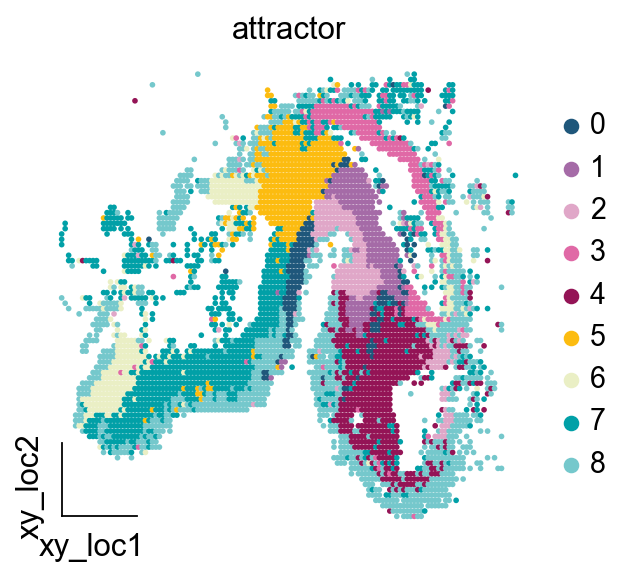

In [12]:
ov.pl.embedding(adata, basis="xy_loc", 
                color=["attractor"],frameon='small',
               palette=ov.pl.sc_color[11:])

/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/omicverse/utils/_scatterplot.py:417: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


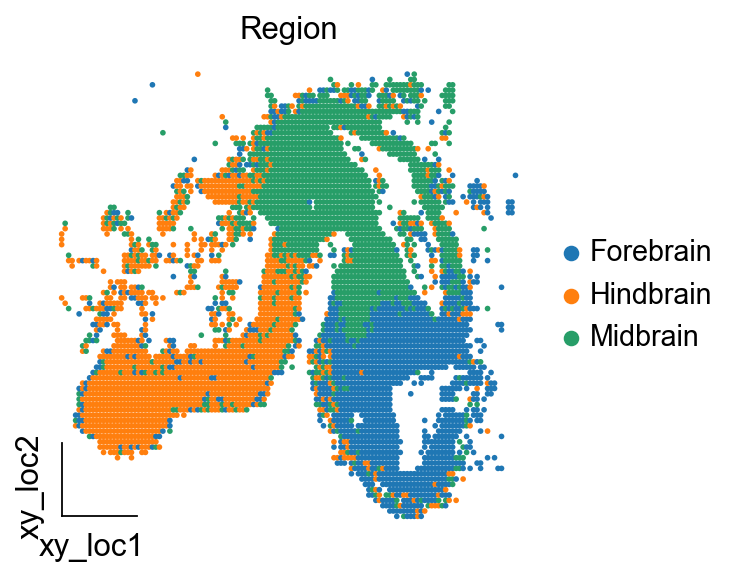

In [7]:
ov.pl.embedding(adata, basis="xy_loc", 
                color=["Region"],frameon='small',
               )

## Pathway analysis

In the original tutorial, the author encapsulated the `gseapy==1.0.4` version for access enrichment. Note that the use of this function requires networking, which we have modified so that we can enrich using the local pathway dataset

We can download good access data directly in [enrichr](https://maayanlab.cloud/Enrichr/#libraries), such as the `KEGG_2019_mouse` used in this study.

https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName=KEGG_2019_Mouse

In [8]:
pathway_dict=ov.utils.geneset_prepare('genesets/KEGG_2019_Mouse.txt',organism='Mouse')

In [ ]:
STT_obj.compute_pathway(pathway_dict)

After running the function, we can use the `plot_pathway` function to visualize the similairty between pathway dynamics in the low dimensional embeddings.

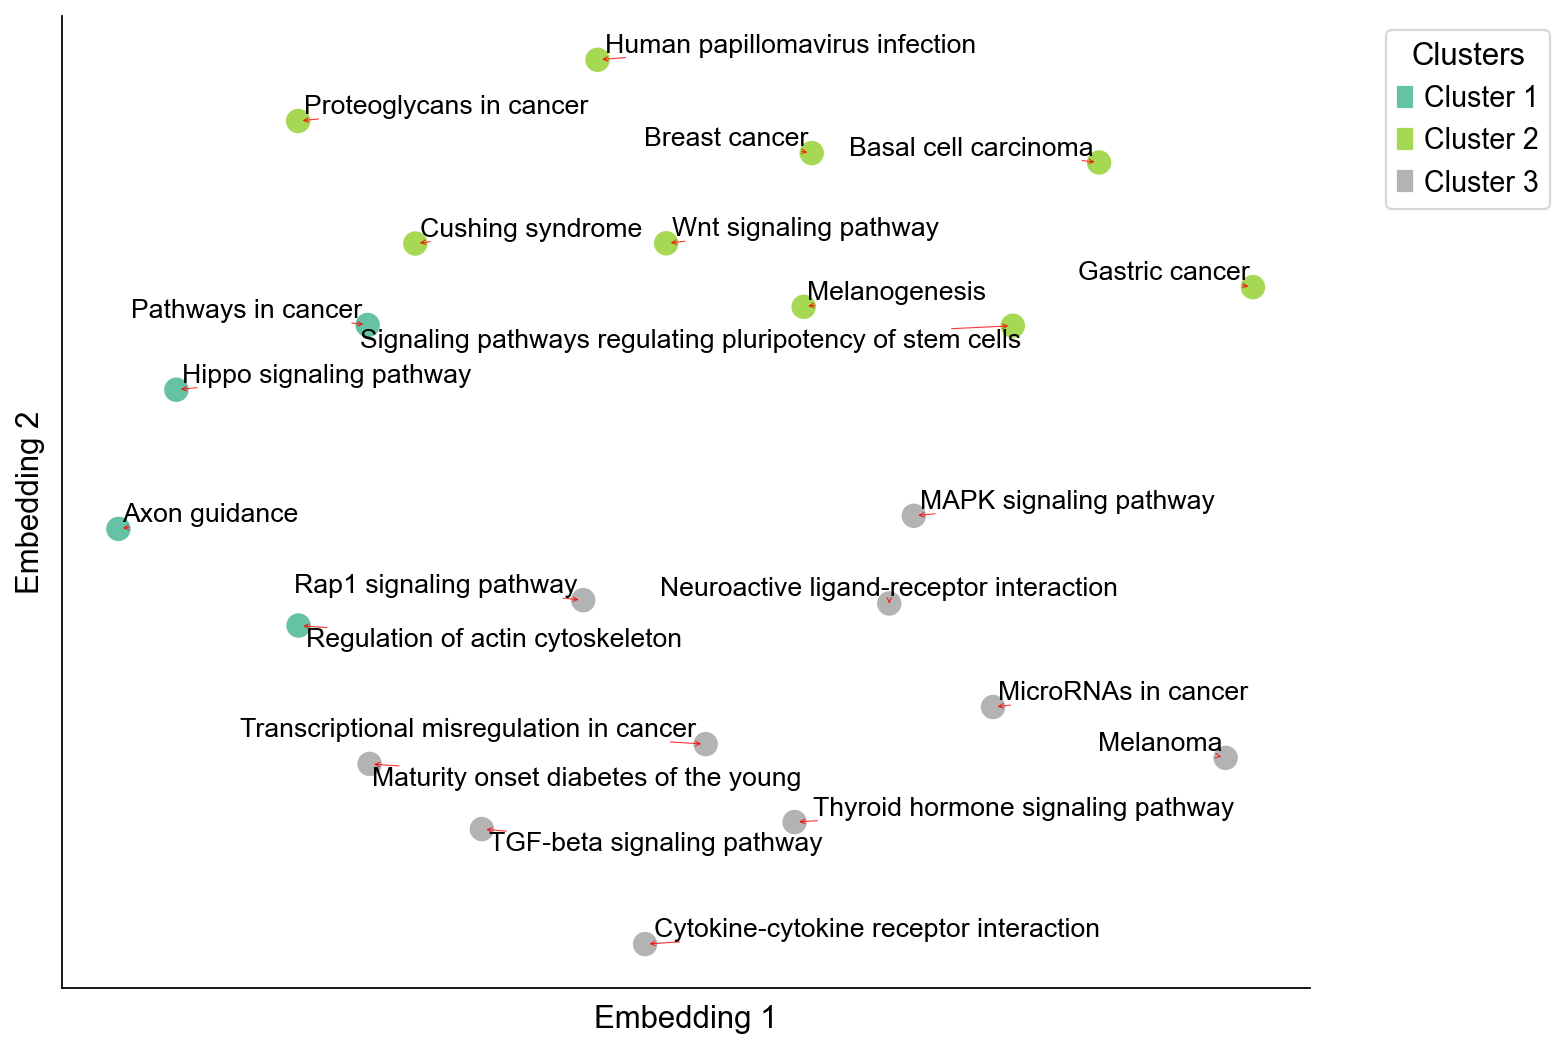

In [11]:
fig = STT_obj.plot_pathway(figsize = (10,8),size = 100,fontsize = 12)
for ax in fig.axes:
    ax.set_xlabel('Embedding 1', fontsize=20)  # Adjust font size as needed
    ax.set_ylabel('Embedding 2', fontsize=20)  # Adjust font size as needed
fig.show()

If we are interested in the specific pathways, we can use the `plot_tensor_pathway` function to visualize the streamlines.

check that the input includes aggregated object
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/scvelo/tools/velocity_graph.py:375: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{vkey}_graph"] = vgraph.graph


    finished (0:00:02) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


<AxesSubplot: title={'center': 'All attractors,Joint'}>

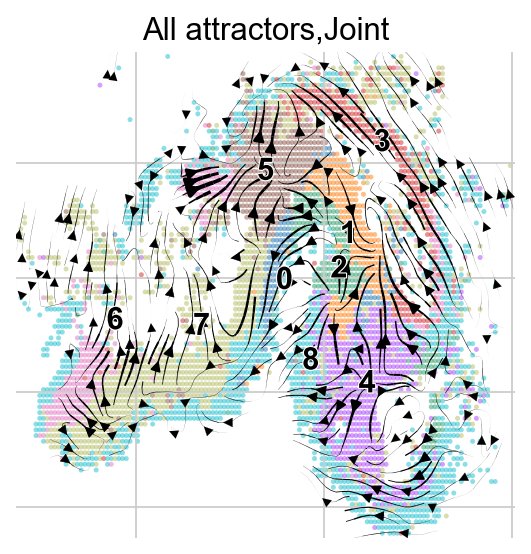

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
STT_obj.plot_tensor_pathway(pathway_name = 'Wnt signaling pathway',basis = 'xy_loc',
                           ax=ax)

check that the input includes aggregated object
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/scvelo/tools/velocity_graph.py:375: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"{vkey}_graph"] = vgraph.graph


    finished (0:00:02) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)


<AxesSubplot: title={'center': 'All attractors,Joint'}>

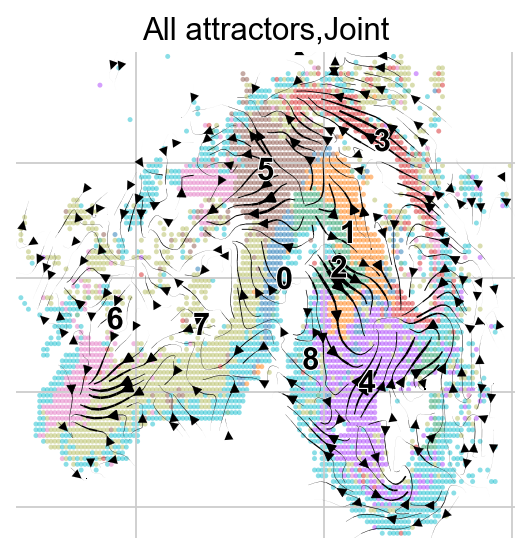

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
STT_obj.plot_tensor_pathway( 'TGF-beta signaling pathway',basis = 'xy_loc',
                           ax=ax)

## Tensor analysis

In the author's original paper, a very interesting concept is mentioned, attractor-averaged and attractor-specific tensors.

We can analyse the Joint Tensor and thus study the steady state processes of different attractors. If the streamlines are passing through the attractor then the attractor is in a steady state, if the streamlines are emanating/converging from the attractor then the attractor is in a dynamic state.

In addition to this, the Unspliced Tensor also reflects the strength as well as the size of the attraction.

check that the input includes aggregated object
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:09) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
check that the input includes aggregated object
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'vj_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vj_xy_loc', embedded velocity vectors (adata.obsm)
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vs_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vs_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)
computing velocity graph (using 12/12 cores)


  0%|          | 0/4628 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vu_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vu_xy_loc_aggr', embedded velocity vectors (adata.obsm)


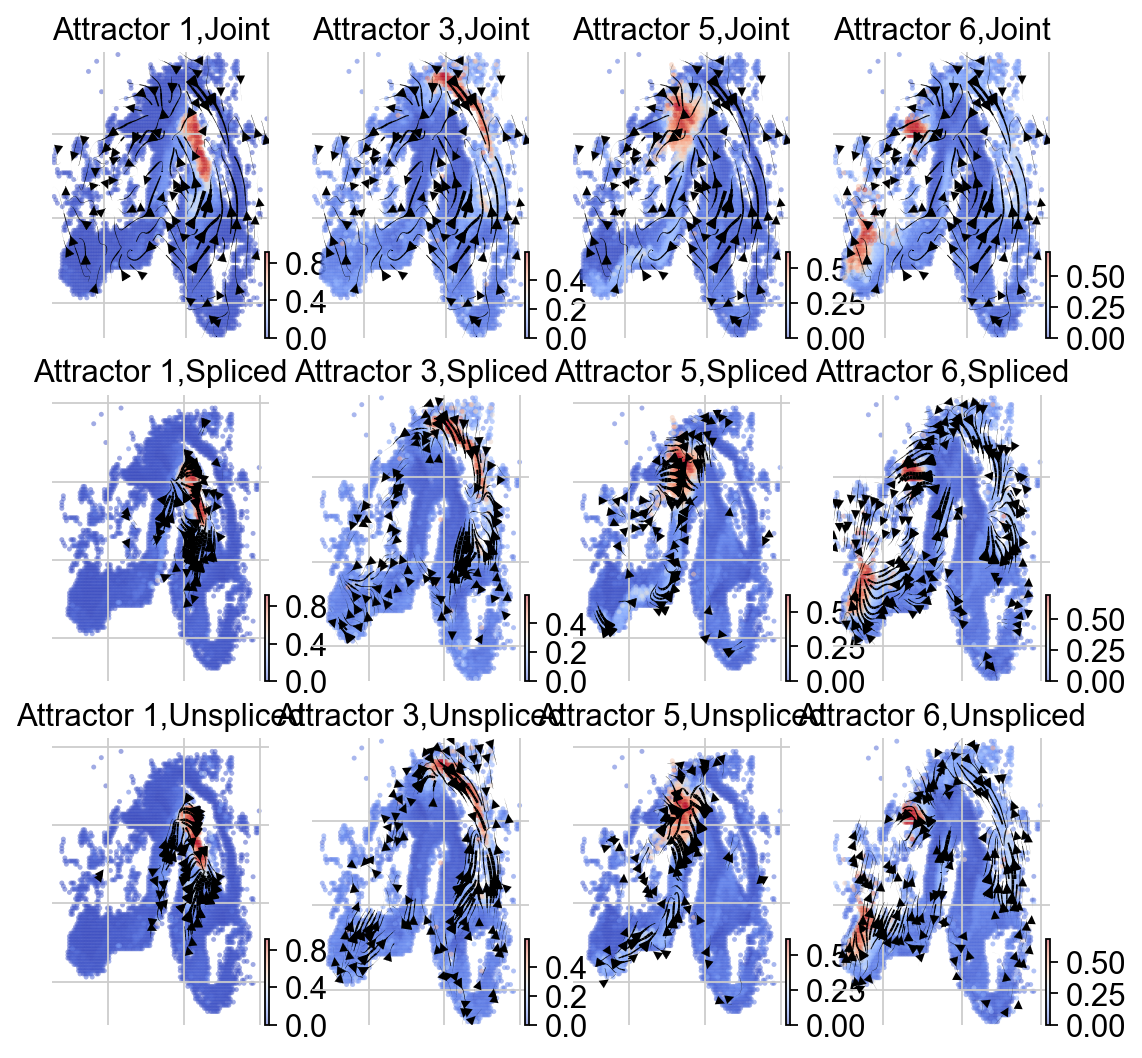

In [4]:
STT_obj.plot_tensor(list_attractor = [1,3,5,6],
                filter_cells = True, member_thresh = 0.1, density = 1)


## Landscape analysis

Each attractor corresponds to a spatial steady state, then we can use contour plots to visualise this steady state and use CellRank's correlation function to infer state transitions between different attractors.

In [17]:
STT_obj.construct_landscape(coord_key = 'X_xy_loc')

/mnt/home/zehuazeng/miniconda3/envs/omicverse/lib/python3.8/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


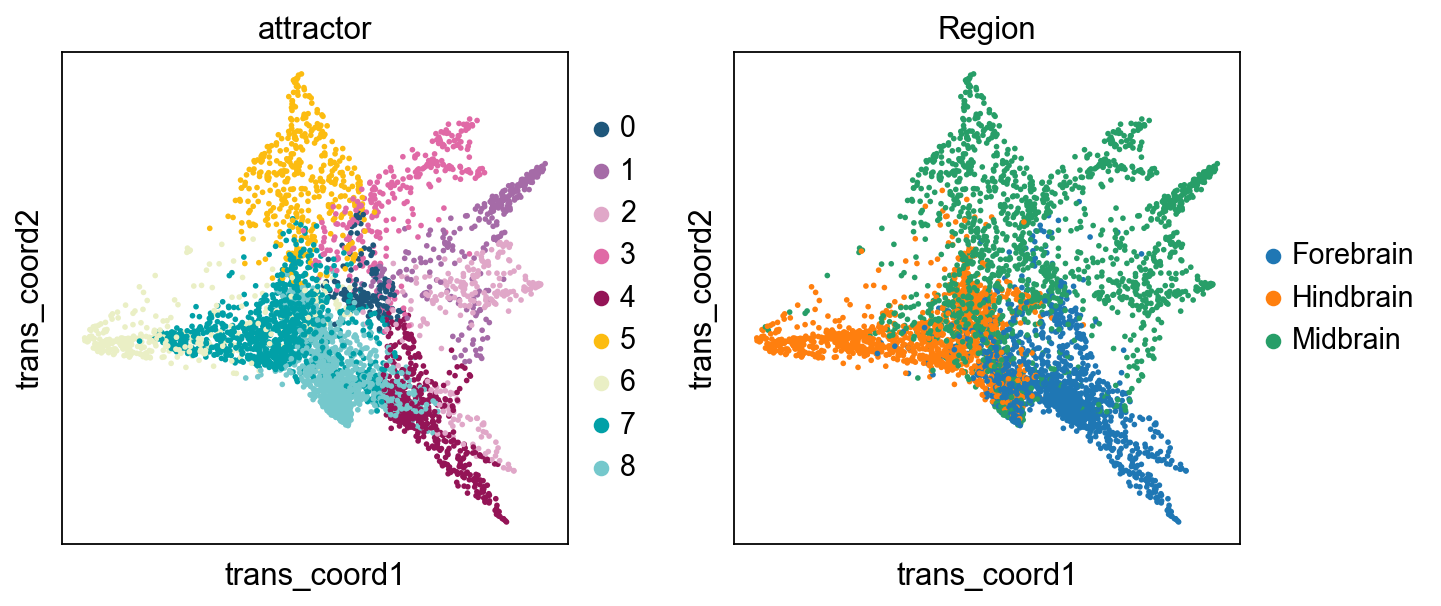

In [14]:
sc.pl.embedding(adata, color = ['attractor', 'Region'],basis= 'trans_coord')

Method to infer the lineage, either ‘MPFT’(maxium probability flow tree, global) or ‘MPPT’(most probable path tree, local)

<AxesSubplot: >

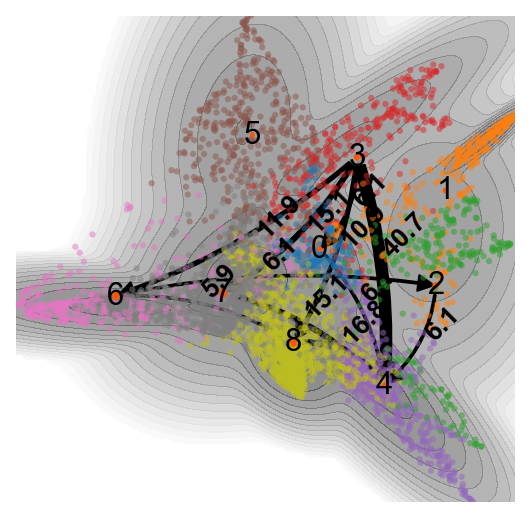

In [15]:
STT_obj.infer_lineage(si=3,sf=4, method = 'MPPT',flux_fraction=0.8,color_palette_name = 'tab10',size_point = 8,
                   size_text=12)

The Sankey plot displaying the relation between STT attractors (left) and spatial region annotations (right). The width of links indicates the number of cells that share the connected attractor label and region annotation label simultaneously

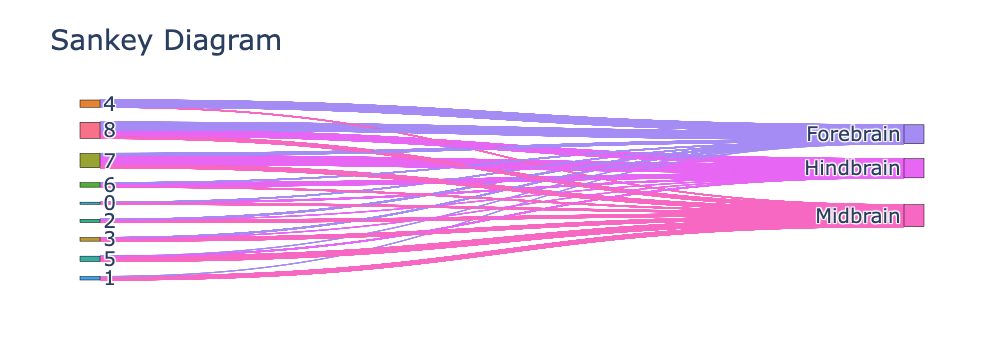

In [16]:
fig = STT_obj.plot_sankey(adata.obs['attractor'].tolist(),adata.obs['Region'].tolist())

## Saving and Loading Data

We need to save the data after the calculation is complete, and we provide the load function to load it directly in the next analysis without having to re-analyse it.

In [24]:
#del adata.uns['r2_keep_train']
#del adata.uns['r2_keep_test']
#del adata.uns['kernel']
#del adata.uns['kernel_connectivities']

STT_obj.adata.write('data/mouse_brain_adata.h5ad')
STT_obj.adata_aggr.write('data/mouse_brain_adata_aggr.h5ad')

In [2]:
adata=ov.read('data/mouse_brain_adata.h5ad')
adata_aggr=ov.read('data/mouse_brain_adata_aggr.h5ad')

In [3]:
STT_obj=ov.space.STT(adata,spatial_loc='xy_loc',region='Region')
STT_obj.load(adata,adata_aggr)

## Gene Dynamic

The genes with high multistability scores possess varying expression levels in both unspliced and spliced counts within various attractors, and show a gradual change during stage transitions. These gene were stored in `adata.var['r2_test']`



In [18]:
adata.var['r2_test'].sort_values(ascending=False)

Lrtm1     0.643272
Pax5      0.611002
Rspo2     0.596486
Stum      0.595376
Dmrt1     0.595088
            ...   
Irx1     -0.337963
Bambi    -0.361296
Pou3f1   -0.367426
Fzd10    -0.379495
Ostm1    -0.988888
Name: r2_test, Length: 117, dtype: float64

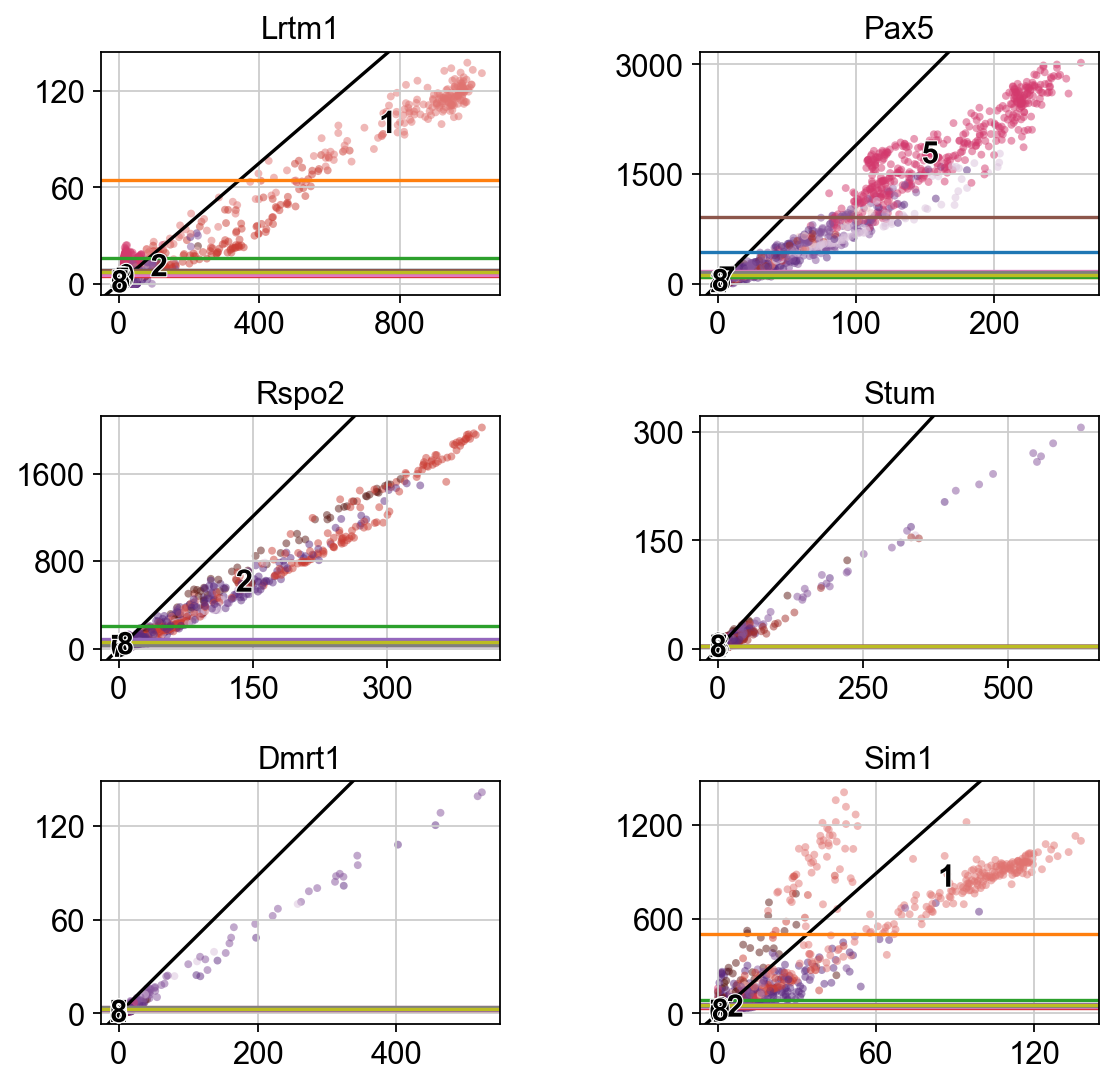

In [11]:
STT_obj.plot_top_genes(top_genes = 6, ncols = 2, figsize = (8,8),)

We analysed the attractor 1-related gene Sim1, and we found that in the unspliced Mu matrix (smooth unspliced), Sim1 is expressed low at attractor 1; in the spliced matrix Ms, Sim1 is expressed high at attractor 1. It indicates that there is a dynamic tendency of Sim1 gene at attractor 1, i.e., the direction of Sim1 expression is flowing towards attractor 1.

Velo analyses can also illustrate this, although Sim1 expression is not highest at attractor 1.

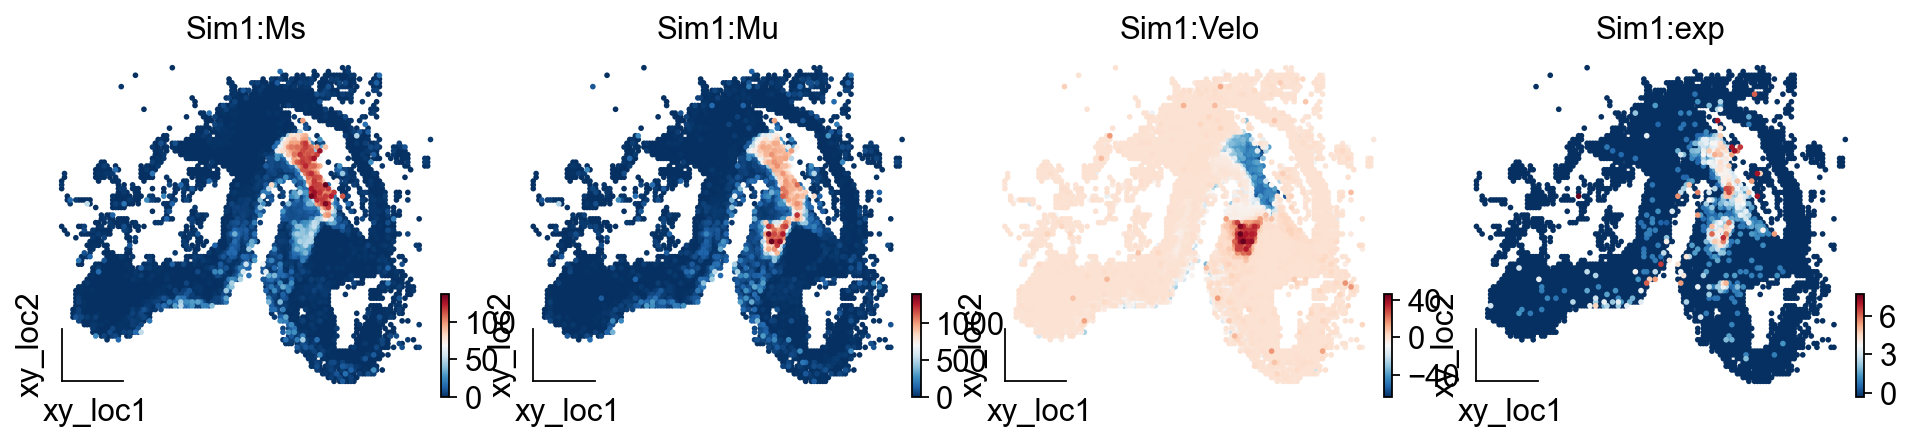

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
ov.pl.embedding(adata, basis="xy_loc", 
                color=["Sim1"],frameon='small',
                title='Sim1:Ms',show=False,
                layer='Ms',cmap='RdBu_r',ax=axes[0]
               )
ov.pl.embedding(adata, basis="xy_loc", 
                color=["Sim1"],frameon='small',
                title='Sim1:Mu',show=False,
                layer='Mu',cmap='RdBu_r',ax=axes[1]
               )
ov.pl.embedding(adata, basis="xy_loc", 
                color=["Sim1"],frameon='small',
                title='Sim1:Velo',show=False,
                layer='velo',cmap='RdBu_r',ax=axes[2]
               )
ov.pl.embedding(adata, basis="xy_loc", 
                color=["Sim1"],frameon='small',
                title='Sim1:exp',show=False,
                #layer='Mu',
                cmap='RdBu_r',ax=axes[3]
               )
plt.tight_layout()